<a href="https://colab.research.google.com/github/Ryul-K/test1/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참고자료 불러오기:
(원본자료)참고 블로그: https://gachonyws.github.io/project/mask-detection/

In [1]:
!git clone https://github.com/mine0123/final.git

Cloning into 'final'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1308 (delta 0), reused 0 (delta 0), pack-reused 1305
Receiving objects: 100% (1308/1308), 75.80 MiB | 9.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# 하드웨어 가속(GPU사용법) : 좌측 상단 "런타임" -> "런타임 유형 변경" -> "None"으로 되어있으면 "GPU"로 변경후 저장

# import library: 라이브러리

In [2]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics



# data preprocessing: 데이터 전처리

In [3]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

dataset = "/content/final/face-mask-detector-master/dataset"# dataset 폴더 경로 적어주기

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

print("[INFO] loading images is completed!!")
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


[INFO] loading images...
[INFO] loading images is completed!!


(1376, 224, 224, 3) (1376, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


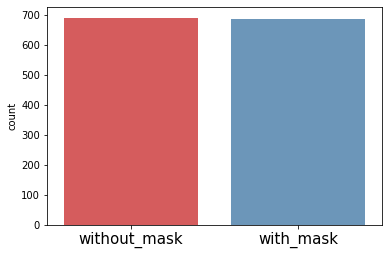

In [4]:
X = data
Y = labels
print(X.shape, Y.shape)

ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask'], rotation=0, fontsize=15)
plt.show()

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)



# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# TrainModel_Sequential

In [5]:
print(trainX.shape, trainY.shape) # 224, 224, 3 -> 이게 펼쳐져서 총 224x224x3 열로 만들어져야 해요

(1100, 224, 224, 3) (1100, 2)


In [6]:
trainX_reshape = trainX.reshape(-1, 224*224*3)
testX_reshape = testX.reshape(-1, 224*224*3)


print(trainX_reshape.shape, testX_reshape.shape) # 224, 224, 3 -> 이게 펼쳐져서 총 224x224x3 열로 만들어져야 해요

(1100, 150528) (276, 150528)


In [7]:
model_Sequential = models.Sequential() 

model_Sequential.add(layers.Dense(input_dim=150528, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model_Sequential.add(layers.BatchNormalization())
model_Sequential.add(layers.Activation('relu')) # layers.ELU or layers.LeakyReLU
model_Sequential.add(layers.Dropout(rate=0.2))

model_Sequential.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model_Sequential.add(layers.BatchNormalization())
model_Sequential.add(layers.Activation('relu')) # layers.ELU or layers.LeakyReLU
model_Sequential.add(layers.Dropout(rate=0.2))

model_Sequential.add(layers.Dense(units=2, activation='softmax')) # 0~9 
model_Sequential.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0

In [8]:
model_Sequential.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [9]:
history_Sequential = model_Sequential.fit(
	trainX_reshape, trainY, batch_size=BS,
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX_reshape, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4685 - categorical_accuracy: 0.7969 - val_loss: 0.4378 - val_categorical_accuracy: 0.8906
Epoch 2/20
34/34 [==============================] - 1s 16ms/step - loss: 0.2866 - categorical_accuracy: 0.8801 - val_loss: 0.1909 - val_categorical_accuracy: 0.9297
Epoch 3/20
34/34 [==============================] - 1s 17ms/step - loss: 0.2097 - categorical_accuracy: 0.9204 - val_loss: 0.1801 - val_categorical_accuracy: 0.9453
Epoch 4/20
34/34 [==============================] - 1s 16ms/step - loss: 0.1590 - categorical_accuracy: 0.9335 - val_loss: 0.1227 - val_categorical_accuracy: 0.9453
Epoch 5/20
34/34 [==============================] - 1s 16ms/step - loss: 0.1420 - categorical_accuracy: 0.9419 - val_loss: 0.1847 - val_categorical_accuracy: 0.9297
Epoch 6/20
34/34 [==============================] - 1s 16ms/step - loss: 0.0928 - categorical_accuracy: 0.9644 - val_loss: 0.1475 - val_categorical_accuracy: 0.9492
Epoch 7/20

In [10]:
history_Sequential.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

# TrainModel_MobileNetV2 (전이 학습 모델)

In [13]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_MobileNetV2 = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_MobileNetV2.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model_MobileNetV2.summary()

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                     

In [14]:

# train the head of the network
print("[INFO] training head...")
history_MobileNetV2 = model_MobileNetV2.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model_MobileNetV2.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))




[INFO] training head...
Epoch 1/20
34/34 [==============================] - 11s 320ms/step - loss: 0.3869 - accuracy: 0.8305 - val_loss: 0.1120 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 10s 294ms/step - loss: 0.1264 - accuracy: 0.9607 - val_loss: 0.0499 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 10s 293ms/step - loss: 0.0845 - accuracy: 0.9757 - val_loss: 0.0343 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 10s 293ms/step - loss: 0.0595 - accuracy: 0.9813 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 5/20
34/34 [==============================] - 10s 294ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 10s 293ms/step - loss: 0.0426 - accuracy: 0.9850 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 10s 293ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.012

# TrainModel_inceptionV3 (전이 학습 모델)

In [19]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)) 
# pre_trained_model.summary()
# include_top : 가장 상단의 fully connected 계층들을 포함 시킬지의 여부입니다.
# weight : 케라스에서 미리 pretraining 시켜놓은 weight을 사용 할 것인지 여부입니다.
# input_shape : (img_width, img_height, img_channel(RGB))



for layer in pre_trained_model.layers:       #transfer learning(전이학습모델) ; inceptionV3 model을 불러와 기존 가중치를 학습하지않는다
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# inceptionV3의 'mixed7' 레이어를 마지막 레이어로써 설정하고 해당 레이어의 아웃풋을 저장한다.
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output
print(last_output)    

#feature engineering -> 선형결합 -> batch normalization -> activation func -> dropdout   세팅
x = tf.keras.layers.Flatten()(last_output)   # inceptionV3 모델의 mixed7레이어의 아웃풋을 이미지 데이터 1차원 처리후
x = tf.keras.layers.Dense(1024, activation='relu')(x) # input처리, 활성화함수: relu
x = tf.keras.layers.Dropout(0.3)(x)  # 30% 드랍아웃
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(2, activation='softmax')(x) # 최종 결과 인덱싱이 without, with, 2분류

model_inceptionV3 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x) 

model_inceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #adam, adagrad, rmsprop
model_inceptionV3.summary()

87916544/87910968 [==============================] - 2s 0us/step
Last layer output shape : (None, 12, 12, 768)
Tensor("mixed7/concat:0", shape=(None, 12, 12, 768), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activat

In [20]:
history_inceptionV3 = model_inceptionV3.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 12s 344ms/step - loss: 1.1332 - acc: 0.9279 - val_loss: 1.5981e-08 - val_acc: 1.0000
Epoch 2/20
34/34 [==============================] - 10s 308ms/step - loss: 0.2862 - acc: 0.9785 - val_loss: 0.0278 - val_acc: 0.9964
Epoch 3/20
34/34 [==============================] - 10s 305ms/step - loss: 0.1884 - acc: 0.9831 - val_loss: 1.7514e-06 - val_acc: 1.0000
Epoch 4/20
34/34 [==============================] - 10s 308ms/step - loss: 0.1213 - acc: 0.9888 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/20
34/34 [==============================] - 10s 308ms/step - loss: 0.1808 - acc: 0.9916 - val_loss: 0.0124 - val_acc: 0.9964
Epoch 6/20
34/34 [==============================] - 10s 308ms/step - loss: 0.0848 - acc: 0.9897 - val_loss: 0.0049 - val_acc: 0.9964
Epoch 7/20
34/34 [==============================] - 10s 308ms/step - loss: 0.1830 - acc: 0.9878 - val_loss: 0.0916 - val_acc: 0.9928
Epoch 8/20
34/34 [==============================] - 10s 3

# 트레이닝 모델 시각화

In [21]:
history_inceptionV3.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

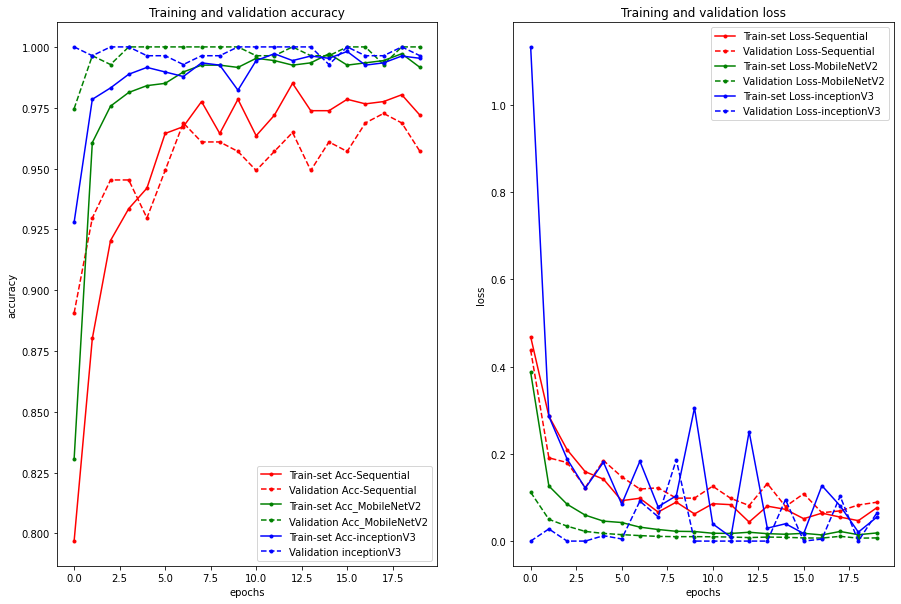

In [23]:
# history for Sequential Model
acc_Sequential = history_Sequential.history['categorical_accuracy']
val_acc_Sequential = history_Sequential.history['val_categorical_accuracy']
loss_Sequential = history_Sequential.history['loss']
val_loss_Sequential = history_Sequential.history['val_loss']

# history for MobileNetV2 Model
acc_MobileNetV2 = history_MobileNetV2.history['accuracy']
val_acc_MobileNetV2 = history_MobileNetV2.history['val_accuracy']
loss_MobileNetV2 = history_MobileNetV2.history['loss']
val_loss_MobileNetV2 = history_MobileNetV2.history['val_loss']

# history for inceptionV3 Model
acc_inceptionV3 = history_inceptionV3.history['acc']
val_acc_inceptionV3 = history_inceptionV3.history['val_acc']
loss_inceptionV3 = history_inceptionV3.history['loss']
val_loss_inceptionV3 = history_inceptionV3.history['val_loss']


plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.plot(acc_Sequential, marker='.', c='r', label="Train-set Acc-Sequential")
plt.plot(val_acc_Sequential, marker='.', c='r', ls='--', label='Validation Acc-Sequential')

plt.plot(acc_MobileNetV2, marker='.', c='g', label="Train-set Acc_MobileNetV2")
plt.plot(val_acc_MobileNetV2, marker='.', c='g', ls='--', label='Validation Acc_MobileNetV2')

plt.plot(acc_inceptionV3, marker='.', c='b', label="Train-set Acc-inceptionV3")
plt.plot(val_acc_inceptionV3, marker='.', c='b', ls='--', label='Validation inceptionV3')

plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss_Sequential, marker='.', c='r', label='Train-set Loss-Sequential')
plt.plot(val_loss_Sequential, marker='.', c='r', ls='--', label='Validation Loss-Sequential')

plt.plot(loss_MobileNetV2, marker='.', c='g', label='Train-set Loss-MobileNetV2')
plt.plot(val_loss_MobileNetV2, marker='.', c='g', ls='--', label='Validation Loss-MobileNetV2')

plt.plot(loss_inceptionV3, marker='.', c='b', label='Train-set Loss-inceptionV3')
plt.plot(val_loss_inceptionV3, marker='.', c='b', ls='--', label='Validation Loss-inceptionV3')

plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# 트레이닝 모델 저장

In [12]:
model_dir_Sequential = "/content/final/face-mask-detector-master/mask_detector_Sequential.model" # please input "path to output face mask detector model"

model_Sequential.save(model_dir_Sequential, save_format="h5")

In [18]:
model_dir_MobileNetV2 = "/content/final/face-mask-detector-master/mask_detector_MobileNetV2.model" # please input "path to output face mask detector model"

model_MobileNetV2.save(model_dir_MobileNetV2, save_format="h5")

In [24]:
model_dir_inceptionV3 = "/content/final/face-mask-detector-master/mask_detector_inceptionV3.model" # please input "path to output face mask detector model"

model_inceptionV3.save(model_dir_inceptionV3, save_format="h5")

# 모델 로드 (Open CV 사용)

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import cv2

# 사진 속에서 얼굴을 탐지하는 모델 (face_detector)
facenet = cv2.dnn.readNet('/content/final/face-mask-detector-master/face_detector/deploy.prototxt','/content/final/face-mask-detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel')
# 얼굴인식 후 마스크 착용 여부를 확인하는 모델 (mask_detector)
load_model_Sequential = load_model('/content/final/face-mask-detector-master/mask_detector_Sequential.model')
load_model_MobileNetV2 = load_model('/content/final/face-mask-detector-master/mask_detector_MobileNetV2.model')
load_model_inceptionV3 = load_model('/content/final/face-mask-detector-master/mask_detector_inceptionV3.model')

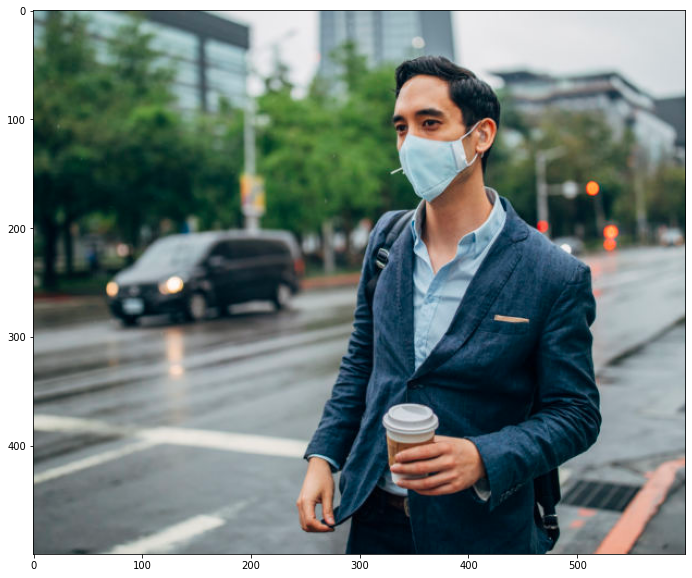

In [28]:
# OpenCV를 사용해서 사진을 matplotlib 으로 화면에 출력
# OpenCV → BGR 순서로 저장 /  matplotlib → RGB 순서로 저장 / 따라서 BGR을 RGB로 바꾸어 주는 작업 필요

img = cv2.imread('/content/final/face-mask-detector-master/examples/example_01.png')
h,w = img.shape[:2]
plt.figure(figsize=(16,10))
plt.imshow(img[:,:,::-1]) # BGR -> RGB 변환

In [29]:
blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0, size = (300, 300), mean = (104.0, 177.0, 123.0))
# blob을 통해 얼굴 학습 (불러올 이미지, 이미지 크기 조절 유무, 신경망이 예상하는 이미지의 크기, 평균 빼기값)
facenet.setInput(blob) # 얼굴 탐지 모델에 들어가는 input
detections = facenet.forward() # output

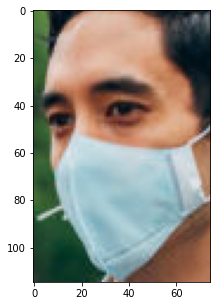

In [30]:
faces = []

# 사진속 얼굴 개수가 여러 개 있을 수 있으니 반복문 사용
for i in range(detections.shape[2]):
  confidence = detections[0,0,i,2] # 4차원 배열에서 사람의 얼굴이라고 인식된 부분들 → 이미지로 출력될 부분

  if confidence < 0.5: # 사람의 얼굴로 인식될 정확도 (50%)
    continue
  else:
     x1 = int(detections[0,0,i,3] * w) # 박스 시작점의 x좌표 상대위치 (왼쪽 맨 위)
     y1 = int(detections[0,0,i,4] * h) # 박스 시작점의 y좌표 상대위치
     x2 = int(detections[0,0,i,5] * w) # 박스 끝점의 x좌표 상대위치 (오른쪽 맨 아래)
     y2 = int(detections[0,0,i,6] * h) # 박스 끝점의 y좌표 상대위치

     face = img[y1:y2, x1:x2]
     faces.append(face)

plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])


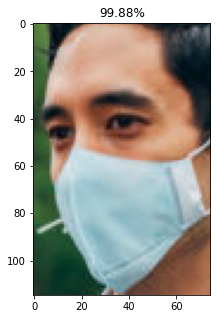

In [43]:
plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    face_input = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_input = cv2.resize(face_input, dsize=(224, 224))
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)
    #face_input2 = face_input.reshape(-1, 224*224*3)
    (mask, nomask) = load_model_MobileNetV2.predict(face_input)[0]  # load_model_Sequential.predict(face_input2)[0], load_model_inceptionV3.predict(face_input)

    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))

# detect_mask_video (동영상에서 실행)

In [45]:

cap = cv2.VideoCapture('/content/final/face-mask-detector-master/examples/03.mp4')
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/final/face-mask-detector-master/result_video/output_MobileNetV3.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)
        face_input2 = face_input.reshape(-1, 224*224*3)

        mask, nomask = load_model_MobileNetV2.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0) # Green 마스크 착용
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255) # Red 마스크 미착용
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()

In [46]:

cap = cv2.VideoCapture('/content/final/face-mask-detector-master/examples/03.mp4')
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/final/face-mask-detector-master/result_video/output_inceptionV3.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)
        face_input2 = face_input.reshape(-1, 224*224*3)

        mask, nomask = load_model_inceptionV3.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0) # Green 마스크 착용
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255) # Red 마스크 미착용
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()

In [47]:

cap = cv2.VideoCapture('/content/final/face-mask-detector-master/examples/03.mp4')
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/final/face-mask-detector-master/result_video/output_Sequential.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)
        face_input2 = face_input.reshape(-1, 224*224*3)

        mask, nomask = load_model_Sequential.predict(face_input2).squeeze()

        if mask > nomask:
            color = (0, 255, 0) # Green 마스크 착용
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255) # Red 마스크 미착용
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()

# 새 섹션

# 새 섹션

In [26]:
pwd

'/content'